In [7]:
#Import all the necessary libraries
import json, sys, random
import numpy as np
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

In [9]:
##Load the data for the model
with open('ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
#Shipsnet= pd.DataFrame(dataset)
#print(Shipsnet.head())

In [10]:
#Define the data to be used for the model. These are structured as tuples.
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [11]:
input_data.shape
#The input shape are the 4000 thousand images with pixel value of 19200 integers.
#It is the equivalent of 6400 of each of the color channels (RGB)

(4000, 19200)

In [12]:
#The following step is reshape the image to be able to visualize. 
#The tuple is reshape as the three color spectrum, and the image with a size of 80x80 
n_spectrum = 3 # color chanel (RGB)
width = 80
height = 80
X = input_data.reshape([-1, n_spectrum, width, height])
X[0].shape

(3, 80, 80)

In [19]:
#One of the pictures show in the three different spectrums and 
#the plot of the three channels in the box below
pic = X[6]

red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectrum = pic[2]

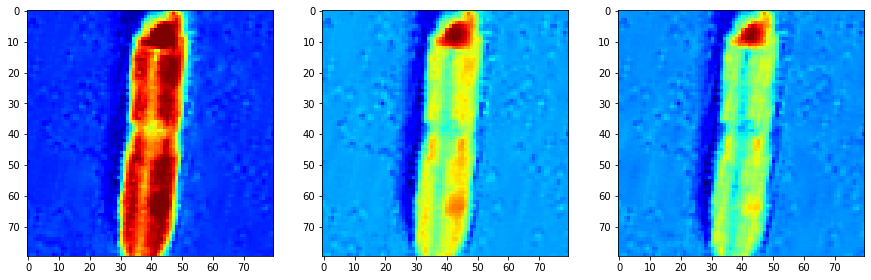

In [20]:
plt.figure(2, figsize = (5*3, 5*1))

# Now it is possible to visualize the image in each of its color spectrums 
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)
    
plt.show()

In [21]:
#Check the labels and the values. It count the labels for each of the classes. The class
#labels consists in 3000 of 'no-ships' and 1000 of 'ships'.
output_data.shape

(4000,)

In [22]:
#Count number of 1 and 0 (Ship and no-Ship respectively)
np.bincount(output_data)

array([3000, 1000])

In [23]:
# output encoding or transforming the labels into categorical data for the classifier
y = np_utils.to_categorical(output_data, 2)

In [24]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

In [25]:
#fixing the X dataset using transpose. The channels will be at the end.  
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [26]:
# normalization of the values so it will be between the range 0 to 1
X_train = X_train / 255

In [27]:
np.random.seed(42)

In [28]:
# network design. It has different Convolutional layers to extract the important features
#The MaxPooling layer is used to downsample the image and allow to focus in the features
#in the sub-regions. The softmax will give you a final probability that will answer the question
#ship or not-ship

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [29]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training setup
training_results = model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)


Train on 2240 samples, validate on 560 samples
Epoch 1/18
 - 15s - loss: 0.3634 - accuracy: 0.8379 - val_loss: 0.1835 - val_accuracy: 0.9393
Epoch 2/18
 - 18s - loss: 0.1334 - accuracy: 0.9522 - val_loss: 0.1130 - val_accuracy: 0.9607
Epoch 3/18
 - 18s - loss: 0.1212 - accuracy: 0.9616 - val_loss: 0.0676 - val_accuracy: 0.9804
Epoch 4/18
 - 20s - loss: 0.1002 - accuracy: 0.9688 - val_loss: 0.0658 - val_accuracy: 0.9875
Epoch 5/18
 - 21s - loss: 0.0779 - accuracy: 0.9750 - val_loss: 0.0498 - val_accuracy: 0.9929
Epoch 6/18
 - 20s - loss: 0.0546 - accuracy: 0.9830 - val_loss: 0.0622 - val_accuracy: 0.9804
Epoch 7/18
 - 20s - loss: 0.0615 - accuracy: 0.9795 - val_loss: 0.0450 - val_accuracy: 0.9893
Epoch 8/18
 - 20s - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.0499 - val_accuracy: 0.9821
Epoch 9/18
 - 20s - loss: 0.0523 - accuracy: 0.9857 - val_loss: 0.0419 - val_accuracy: 0.9857
Epoch 10/18
 - 19s - loss: 0.0377 - accuracy: 0.9871 - val_loss: 0.0275 - val_accuracy: 0.9893
Epoch 11/18

In [102]:
import os 
# serialize weights to HDF5
save_dir = "./"
model_name = 'keras_ship_detector.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./keras_ship_detector.h5 


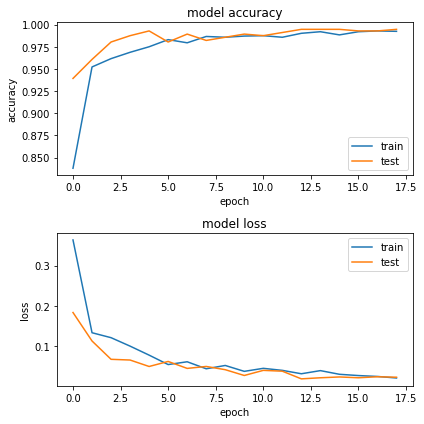

In [31]:
# plotting the metrics
fig = plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(training_results.history['accuracy'])
plt.plot(training_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(training_results.history['loss'])
plt.plot(training_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

plt.show()

In [81]:
#Load the image to apply the model
image = Image.open('ships-in-satellite-imagery/scenes/scenes/sfbay_3.png')
pix = image.load()

In [82]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [83]:
# create a vector. It will go through each of the color spectrum of the image(3 channels)
#to determine the height and width of the image according to the features in each axis.
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [84]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
#The image is converted to an array and then reshaped all the features in to the 3 color channels,
#and the height and width obtained before. Then, it is transposed to have the same format as
#the previous images.

In [69]:
picture_vector.shape

(12816279,)

In [70]:
picture_tensor.shape #format to visualize the image

(1577, 2709, 3)

In [39]:
#plt.figure(1, figsize = (15, 30))
#plt.imshow(picture_tensor)
#plt.show()

In [85]:
picture_tensor = picture_tensor.transpose(2,0,1)

In [86]:
picture_tensor.shape

(3, 1577, 2709)

In [87]:
#Function to determine the area to explore inside the image and determine whether there is a ship or not in that area.
#It goes feature by feature in each of the color spectrums. The values of the area_study are normalized. 

def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [88]:
#It will allow to go through the area of study until it gets to the end of it. 
#Then the analysis ends and continue to the next area
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [89]:
#It shows the finding in the different areas of study with a accuracy that is above the threshold
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:1440 Y:160  [[0.0089945  0.99100554]]


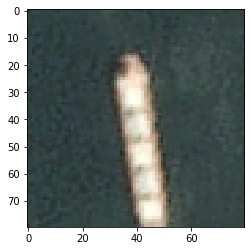

X:1920 Y:160  [[0.00261961 0.9973803 ]]


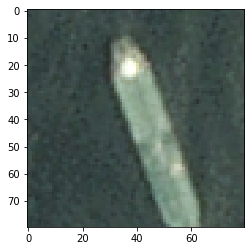

X:1700 Y:190  [[8.808554e-04 9.991191e-01]]


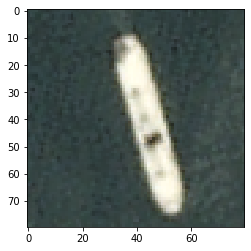

X:740 Y:250  [[0.01230216 0.9876979 ]]


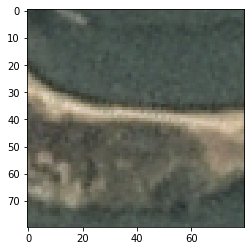

X:820 Y:250  [[0.00145667 0.9985434 ]]


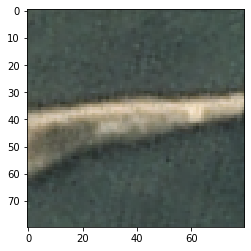

X:1540 Y:550  [[0.01549983 0.98450017]]


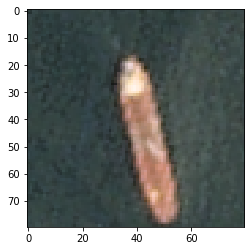

X:1780 Y:580  [[1.7554074e-04 9.9982446e-01]]


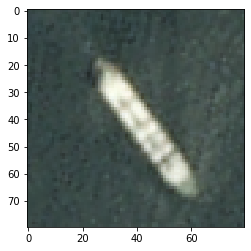

X:1110 Y:750  [[0.00575667 0.9942433 ]]


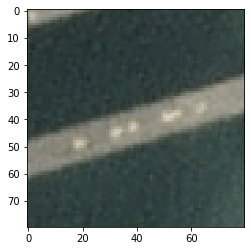

X:1990 Y:750  [[0.00379501 0.99620503]]


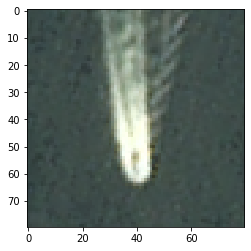

X:1900 Y:920  [[0.01067957 0.9893204 ]]


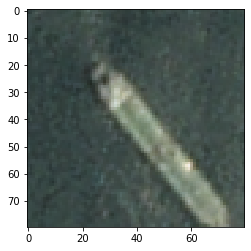

X:1060 Y:930  [[0.00579715 0.9942028 ]]


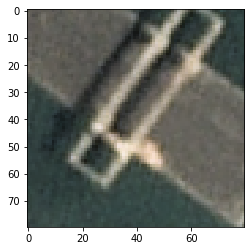

X:2150 Y:930  [[5.706430e-04 9.994293e-01]]


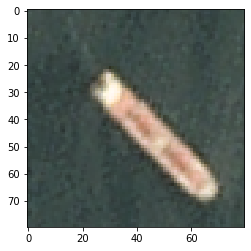

X:1620 Y:940  [[0.00131333 0.9986866 ]]


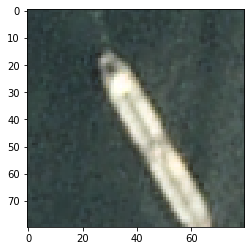

X:1050 Y:1010  [[0.00549546 0.9945045 ]]


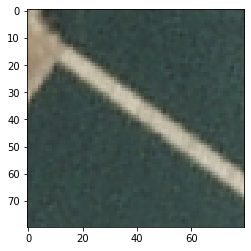

X:1050 Y:1090  [[0.00383697 0.996163  ]]


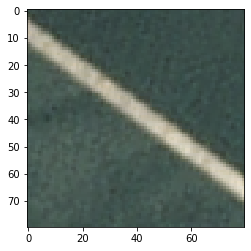

X:960 Y:1100  [[5.6547776e-04 9.9943453e-01]]


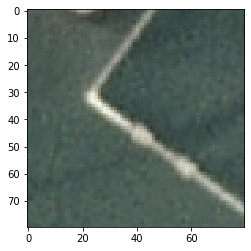

X:2050 Y:1310  [[2.1146516e-04 9.9978858e-01]]


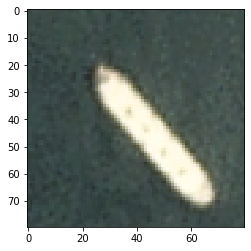

X:630 Y:1330  [[0.01693841 0.98306155]]


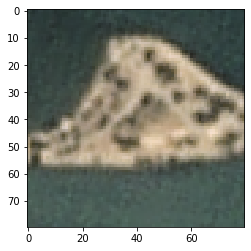

X:2620 Y:1490  

In [90]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step)):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.98 and not_near(x*step,y*step, 80, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

#It will divide the image according to the area of study and the steps to go across it will be of 10. 
#The for loops will make sure it goes through all the image. The model is applied to determine the existence of a 
#ship according to what the NN has learned from the training.

In [91]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [92]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1577, 2709, 3)

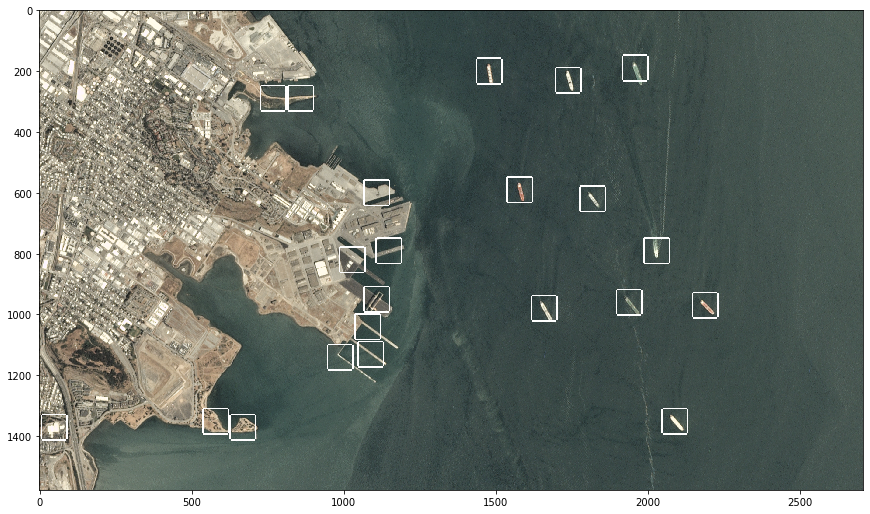

In [49]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

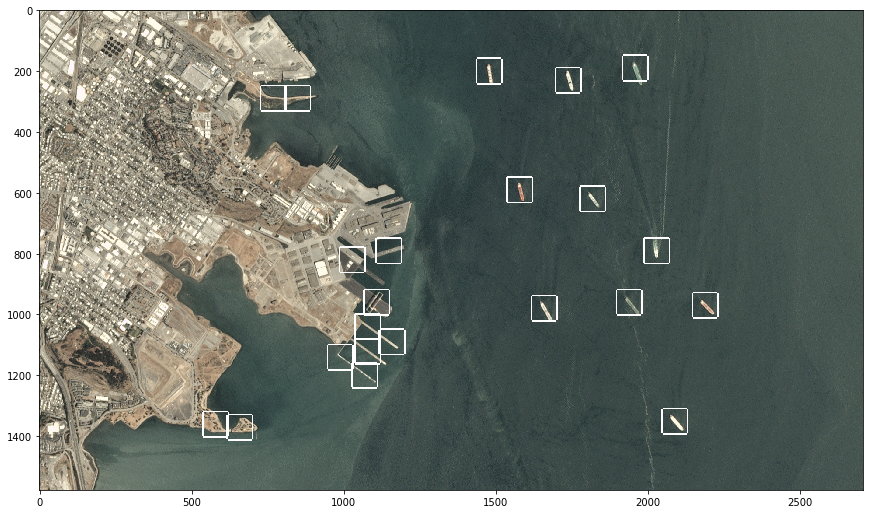

In [79]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

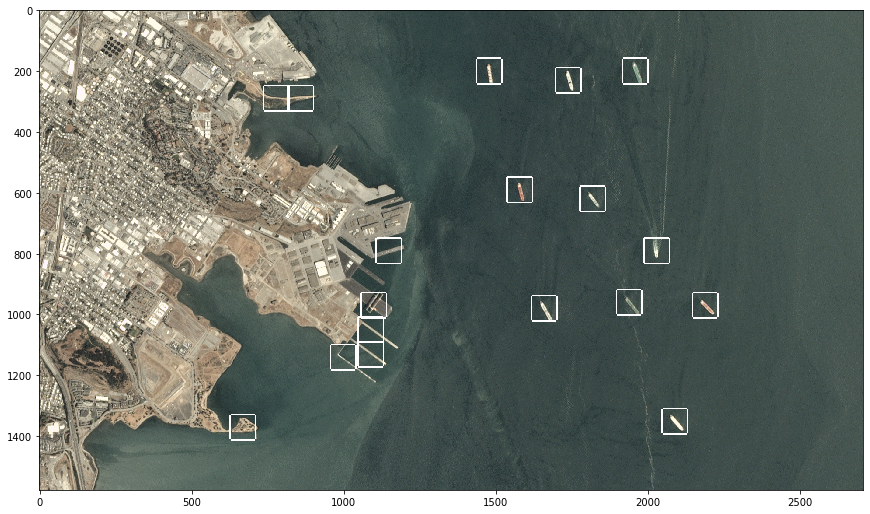

In [93]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

In [94]:
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)




In [97]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("keras_ship_detector.h5")
print("Loaded model from disk")

Loaded model from disk
